# はじめに

Titanic: Machine Learning from Disasterfは、Kaggleの用意したタイタニック号の生存者と故人を予測するコンペティションです。  
機械学習の基礎用として用意されたもので、学習用データは891個のデータから、0を生存者、1を故人として学習させます。この学習モデルから予測したデータをCSV形式にしてサイトにアップロードすると、ランキングとして表示されます。



## データの読み込み
まずはデータと基本的なモジュールを読み込みます。

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#データの読み込み

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# 前処理
## 研究
[過去の研究](https://econ101.jp/%E3%82%BF%E3%82%A4%E3%83%A9%E3%83%BC%E3%83%BB%E3%82%B3%E3%83%BC%E3%82%A8%E3%83%B3-%E3%80%8C%E3%82%BF%E3%82%A4%E3%82%BF%E3%83%8B%E3%83%83%E3%82%AF%E5%8F%B7%E3%81%AE%E6%B2%88%E6%B2%A1%E4%BA%8B%E6%95%85/)によれば、男性よりも女性が、大人より子供が生き残りやすいことが知られています。  
また客室の場所や、客の等級もまた生存可能性を予測しています。兄弟姉妹、配偶者、子供の数は、大家族ほど生存率が低くなります。おそらくは家族を守るために避難が遅れたものと解釈されます。  
Kaggleのデータセットにはありませんが、国籍ではイギリス人よりもアメリカ人の方が生き残りやすいとのことです。  
今回はKaggleのデータセットに含まれる中で、特に重要そうなものを列挙してみます。  

- 性別と年齢(女性・若いほど生存に有利)
- 客室の場所(救命ボードに近い位置ほど有利(と思われる))
- 乗客の等級(客室の場所と関連)
- 乗船している夫婦と兄弟姉妹の数(大家族ほど避難が遅れた)
- チケット(客室の場所と関連)

また、一見すると名と姓はあまり意味がないように見えますが、20世紀初頭のイギリスの乗客であれば、名と姓による社会経済状況(SES)に格差がある可能性はあります[^2]。  
ただ運賃や等級といった、より直接的な指標に比べれば予測力は劣ると思われます。試しに名字だけを抜き出しone-hot形式のダミー変数にして学習させましたが、結果はそれほどよくなかったので、標本数も少ないということもあり今回は名前を使用しない方針で行きます。



[^2]: Gregory Clark, *[Are there Ruling Classes? Surnames and Social Mobility in England, 1800-2011](https://pdfs.semanticscholar.org/530c/b4db0520099a2086cd0ec44261edee15fb5f.pdf)*


In [ ]:
## 欠損値の補完
Titanicデータセットは欠損値を含むので、まずその処理を決めます。

欠損の数
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


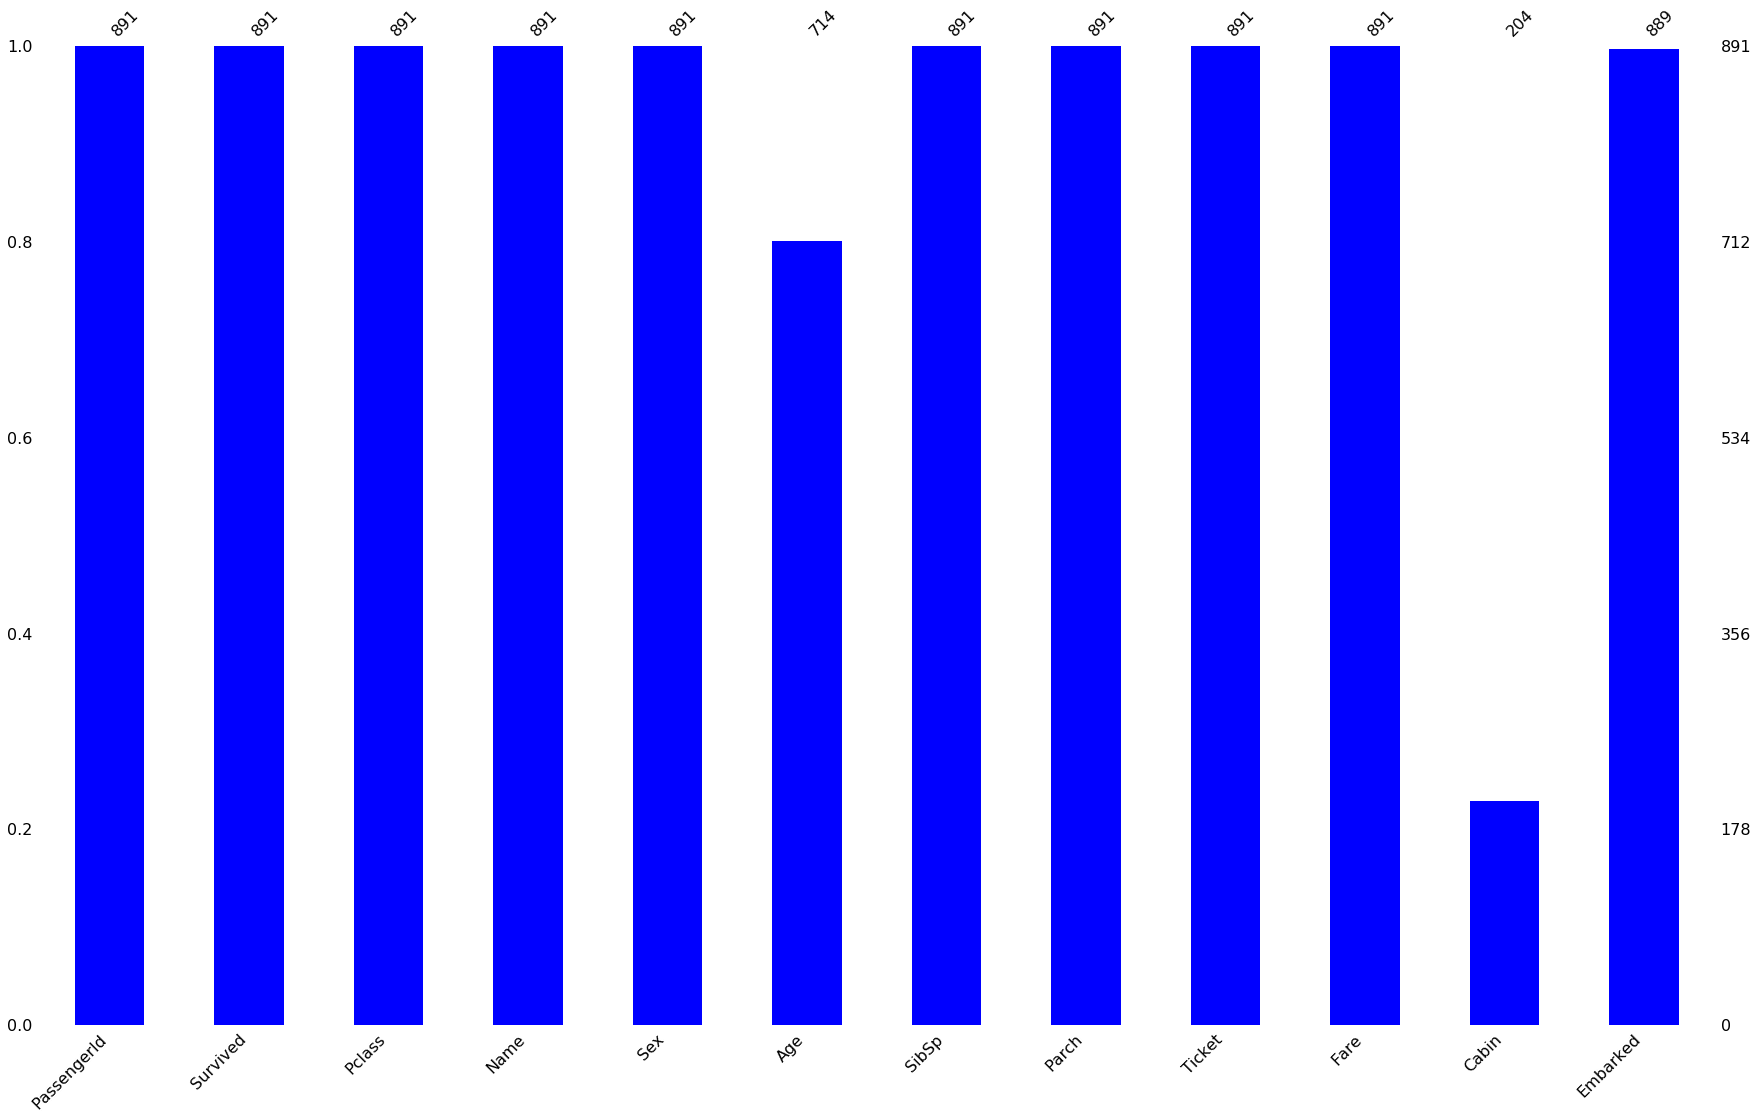

In [5]:
print("欠損数")
print(df_train.isnull().sum())

import missingno as msno

msno.bar(df_train, color="blue", figsize=(30,18))

欠損をグラフで表示すると以上のようになります。  
年齢(Age)の情報は20%ほど欠けていて、逆に船室(Cabin)の情報は約80%ほど欠けています。  
乗船港(Enbarked)は僅か2件ほど欠けています。  
欠損はおそらくランダムではないので、そのまま削除したりはできません。  
欠損値の補完には各種ありますが、正直に言えば詳細を把握できていないというのが本音です。  

今回の分析では、少数の欠損にとどまる乗船港においては最頻値を代入することにします。  
しかし欠損の多い船室については、80%も情報が欠けているということもあって、これを計算で補完するというのは問題があるように思えます。  
かなり多くデータが欠けているので、今回はこのデータは学習に利用しないことにします。  

それでは残る年齢の補完について、二つの方法で検討してみたいと思います。  

## 敬称に基づく補完

In [ ]:
# その敬称の年齢の中央値を取得する
age_median={}
age_median[1] = train_test.query('Age>0 & Name.str.contains("Mr")', engine='python').Age.median()
age_median[2] = train_test.query('Age>0 & Name.str.contains("Mrs")', engine='python').Age.median()
age_median[3] = train_test.query('Age>0 & Name.str.contains("Miss")', engine='python').Age.median()
age_median[4] = train_test.query('Age>0 & Name.str.contains("Master")', engine='python').Age.median()
age_median[5] = train_test.query('Age>0 & Name.str.contains("Dr")', engine='python').Age.median()
age_median[6] = train_test.query('Age>0 & Sex=="female"', engine='python').Age.median()

# 欠損してるデータに、敬称に基づいて中央値を代入する
for i in range(len(train_test)):
    if np.isnan(train_test['Age'][i]):
        if "Mr" in str(train_test['Name'][i]):
            train_test['Age'][i] = age_median[1]
        elif "Mrs" in str(train_test['Name'][i]):
            train_test['Age'][i] = age_median[2]
        elif "Miss" in str(train_test['Name'][i]):
            train_test['Age'][i] = age_median[3]
        elif "Master" in str(train_test['Name'][i]):
            train_test['Age'][i] = age_median[4]
        elif "Dr" in str(train_test['Name'][i]):
            train_test['Age'][i] = age_median[5]
        else:
            train_test['Age'][i] = age_median[6]


欠損した年齢を補完するために、その人物の敬称を利用してみます。

イギリスではMr.、Miss、Dr.など名前の前半部分に敬称が付与され、その人の身分や仕事、職掌を大雑把に把握できるようになっています。  
Mr.やMiss.以外にもRev.(牧師)、Col.(大佐)がありますが、こちらは数が少ないので使用しません。  
代表的な敬称(Mr.,Miss.,Mrs.,Master.,)でほぼ9割の人物で使用されていました。

年齢が欠損している人物には、それぞれの敬称の中央値を利用して割り当てることにします。  
またそれでも一部だけ欠損は残るので、その場合にのみ性別の中央値を割り当てました。
これで全ての人物の年齢が補完されます。

### 多重代入法による補完

In [ ]:
from fancyimpute import MICE

# カラムを取得し、一時保存する()
train_cols = list(train_test_dummies)
train_test_dummies = pd.DataFrame(MICE(verbose=False).complete(train_test_dummies))

# カラムだけ再セット
train_test_dummies.columns = train_cols

もう一つの代入法として、欠損データを補完するための有力な方法と言われる多重代入法を使用します。  
Pythonによる実装では「連鎖方程式による多重代入(MICE)」という手法を使用します。
fancyimputeモジュールを使用すると手軽にMICEを使えるので、今回はこのモジュールを使用してみます[^1]。

[^1]: 最新バージョン(0.4.2)のfancyimputeはMICEクラスが削除されているようなので、バージョン0.3.1をインストールしています。



# 学習モデルを検討する

## スコア表示のできる全ての学習モデルを検討

Pythonの機械学習モジュールでよく使用されるScikit-learnですが、  
あるデータセットに対してscoreメソッドを表示できる全ての機械学習モデルを使用するときall_estimator()を使います。  
このall_estimators()を使えば、SVMやランダムフォレストや回帰分析などを一斉に適用することで、その学習モデルの比較検討を簡単にすることができます。

このとき学習モデルの正解率は把握するため、train.csvのデータセットを学習用データと検証用データに8:2に分割しています。



### 交差検証

一度だけの評価では、データの偏りや汎化能力を評価できません。  
一つのデータセットから複数回検証するため、今回はK分割クロスバリデーションを利用します。  
これはデータをA、B、C……とn個のグループに分割し、  
AとBを学習用データとして使用し、Cを評価用データとして正解率を求める  
BとCを学習用データとして使用し、Aを評価用データとして正解率を求める  
CとAを学習用データとして使用し、Bを評価用データとして正解率を求める  

これらの正解率を単純平均して、その数字を各アルゴリズムの正解率の代表値とします。  
今回は20分割したデータを使用し検証したものの平均を取り、その正解率の平均値が高い順にソートして表示することにします。

## 学習モデル検討用コード・敬称による補完

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


# データの読み込み
train = pd.read_csv("train.csv", dtype={"Age": np.float32}, )
test  = pd.read_csv("test.csv", dtype={"Age": np.float32}, )


# 前処理
## 実際に訓練用データと評価用データを合体させる(今回は訓練データしか使いません)
train_test = pd.concat([train, test], ignore_index=True)

# 欠損値の補完
## Embarked の欠損値の補完
train_test.Embarked = train_test.Embarked.fillna("S")

## 検証用データのFare が欠損値を中央値で補完
train_test.Fare = train_test.Fare.fillna(test.query("Pclass==3").Fare.median())


# 年齢の補完
## その敬称の年齢の中央値を取得する
age_median={}
age_median[1] = train_test.query('Age>0 & Name.str.contains("Mr")', engine='python').Age.median()
age_median[2] = train_test.query('Age>0 & Name.str.contains("Mrs")', engine='python').Age.median()
age_median[3] = train_test.query('Age>0 & Name.str.contains("Miss")', engine='python').Age.median()
age_median[4] = train_test.query('Age>0 & Name.str.contains("Master")', engine='python').Age.median()
age_median[5] = train_test.query('Age>0 & Name.str.contains("Dr")', engine='python').Age.median()
age_median[6] = train_test.query('Age>0 & Sex=="female"', engine='python').Age.median()

# 欠損してるデータに、敬称に基づいて中央値を代入する
for i in range(len(train_test)):
    if np.isnan(train_test['Age'][i]):
        if "Mr" in str(train_test['Name'][i]):
            train_test['Age'][i] = age_median[1]
        elif "Mrs" in str(train_test['Name'][i]):
            train_test['Age'][i] = age_median[2]
        elif "Miss" in str(train_test['Name'][i]):
            train_test['Age'][i] = age_median[3]
        elif "Master" in str(train_test['Name'][i]):
            train_test['Age'][i] = age_median[4]
        elif "Dr" in str(train_test['Name'][i]):
            train_test['Age'][i] = age_median[5]
        else:
            train_test['Age'][i] = age_median[6]

# 使用しないデータを削除
del train_test['Cabin']
del train_test['Name']

## カテゴリ変数をone-hotのダミー変数に変換
train_test_dummies = pd.get_dummies(train_test, columns=['Pclass', 'Sex', 'Embarked','Ticket'])


## 訓練データと評価データに分離
train_dummies = train_test_dummies[train_test_dummies.PassengerId < 892]
test_dummies = train_test_dummies[train_test_dummies.PassengerId >= 892]
del train_dummies['PassengerId']
p_id = test_dummies['PassengerId']# あとで予測用に使用するためp_idに保存する
del test_dummies['PassengerId']

## ラベルデータだけ抜き出してから削除し、残りを学習用データにする
y = train_dummies.loc[:, ["Survived"]]#Pclass以降の変数
del train_dummies['Survived']
x = train_dummies

# サマリーの表示
x.describe()

,Age,Fare,Parch,SibSp,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,...,Ticket_W./C. 14258,Ticket_W./C. 14260,Ticket_W./C. 14263,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.0,891.000000,891.0,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.325668,32.204208,0.381594,0.523008,0.242424,0.206510,0.551066,0.352413,0.647587,0.188552,...,0.001122,0.0,0.001122,0.0,0.002245,0.004489,0.001122,0.001122,0.001122,0.002245
std,13.203681,49.693429,0.806057,1.102743,0.428790,0.405028,0.497665,0.477990,0.477990,0.391372,...,0.033501,0.0,0.033501,0.0,0.047351,0.066890,0.033501,0.033501,0.033501,0.047351
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,14.454200,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,35.000000,31.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,80.000000,512.329200,6.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 学習モデル検討用コード・MICEによる補完

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


# データの読み込み
train = pd.read_csv("train.csv", dtype={"Age": np.float32}, )
test  = pd.read_csv("test.csv", dtype={"Age": np.float32}, )


# 前処理
## 実際に訓練用データと評価用データを合体させる(今回は訓練データしか使いません)
train_test = pd.concat([train, test], ignore_index=True)

## 欠損値の補正
## Embarked の欠損値の補完
train_test.Embarked = train_test.Embarked.fillna("S")

## 検証用データのFare が欠損値を中央値で補完
train_test.Fare = train_test.Fare.fillna(test.query("Pclass==3").Fare.median())

## 不要なデータを削除する
del train_test['Cabin']
del train_test['Name']

## カテゴリ変数をone-hotのダミー変数に変換
train_test_dummies = pd.get_dummies(train_test, columns=['Pclass', 'Sex', 'Embarked', 'Ticket'])

# MICEによる年齢の補完
from fancyimpute import MICE

train_cols = list(train_test_dummies)
train_test_dummies = pd.DataFrame(MICE(verbose=False).complete(train_test_dummies))
train_test_dummies.columns = train_cols

## 訓練データと評価データに分離(今回は訓練データしか使いません)
train_dummies = train_test_dummies[train_test_dummies.PassengerId < 892]
test_dummies = train_test_dummies[train_test_dummies.PassengerId >= 892]

# 不要なデータを削除
del train_dummies['PassengerId']
p_id = test_dummies['PassengerId']# あとで予測用に使用するためp_idに保存する
del test_dummies['PassengerId']

## ラベルデータだけ抜き出してから削除し、残りを学習用データにする
y = train_dummies.loc[:, ["Survived"]]#Pclass以降の変数
del train_dummies['Survived']
x = train_dummies

# サマリーの表示
x.describe()

,Age,Fare,Parch,SibSp,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,...,Ticket_W./C. 14258,Ticket_W./C. 14260,Ticket_W./C. 14263,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.0,891.000000,891.0,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.652443,32.204208,0.381594,0.523008,0.242424,0.206510,0.551066,0.352413,0.647587,0.188552,...,0.001122,0.0,0.001122,0.0,0.002245,0.004489,0.001122,0.001122,0.001122,0.002245
std,13.162496,49.693429,0.806057,1.102743,0.428790,0.405028,0.497665,0.477990,0.477990,0.391372,...,0.033501,0.0,0.033501,0.0,0.047351,0.066890,0.033501,0.033501,0.033501,0.047351
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.894105,14.454200,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,36.000000,31.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,80.000000,512.329200,6.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## all_estimators()による計算
下準備ができたので、実際にall_estimatorsで計算してみます。

In [23]:
from sklearn.metrics import accuracy_score
import warnings
from sklearn.utils.testing import all_estimators
from sklearn.model_selection import train_test_split


# Classifierのアルゴリズムすべてを取得する
warnings.filterwarnings('ignore')
allAlgorithms = all_estimators(type_filter="classifier")

# クロスバリデーション用モジュールを読み込む
from sklearn.model_selection import KFold, cross_val_score

K_FOLD_NUM=20
kfold_cv = KFold(n_splits=K_FOLD_NUM, shuffle=True)


# 保存用
data = pd.DataFrame()

for (name, algorithm) in allAlgorithms:
    if(name == 'RadiusNeighborsClassifier'):continue

    #オブジエクト生成
    clf = algorithm()

    if hasattr(clf,"score"):
        try:
            scores = cross_val_score(clf, x, y, cv=kfold_cv)
            data.at[name,0]=np.mean(scores)
        except:
            pass


print(data.sort_values(0, ascending=False))

                                      0
DecisionTreeClassifier         0.838535
BaggingClassifier              0.838333
RidgeClassifier                0.836288
RidgeClassifierCV              0.832753
ExtraTreesClassifier           0.830758
CalibratedClassifierCV         0.830556
RandomForestClassifier         0.828384
GradientBoostingClassifier     0.822500
LogisticRegression             0.816035
LogisticRegressionCV           0.814747
MLPClassifier                  0.812677
AdaBoostClassifier             0.804545
NuSVC                          0.802475
BernoulliNB                    0.796667
ExtraTreeClassifier            0.795429
LinearSVC                      0.793460
LinearDiscriminantAnalysis     0.749596
GaussianProcessClassifier      0.715051
KNeighborsClassifier           0.709217
SGDClassifier                  0.709040
SVC                            0.703586
ComplementNB                   0.700152
MultinomialNB                  0.697045
LabelSpreading                 0.690960


MICEによる補完をしたデータセットで、 all_estimators()を試してみました。  
有望そうなアルゴリズムの正解率は約84%でかなり良いように見えます。  
実際のKaggleのランキングでいうと、**上位3%に入る好成績だと言えます！**  

実のところこのランキングは毎回微妙に異なり、安定して上位1-3位辺りに入るものRidgeClassifierCVとBaggingClassifierでした。 

また欠損値の補完についても、「敬称による補完」よりも「MICE」を使用したほうがせいか
そこで次からはRidgeClassifierCVとBaggingClassifierについて検討してみることにします。


# ハイパーパラメータの最適化

all_estimators()で使用されたアルゴスリズムは、あくまでデフォルトのパラメータを使用したものです。
実際には人間の手によってパラメータを細かくいじる必要がありますので、
最適なハイパーパラメータを探すため、グリッドサーチを利用してみます。

## RidgeClassifierCVの最適化

In [18]:
# 正解率の計算用
from sklearn.metrics import accuracy_score


# 学習用データとテスト用に分離
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,train_size=0.8,shuffle=True) 

# グリッドサーチ
from sklearn.model_selection import GridSearchCV



# クロスバリデーション用モジュールを読み込む(既に読み込んでますが一応)
from sklearn.model_selection import KFold, cross_val_score

K_FOLD_NUM=20
kfold_cv = KFold(n_splits=K_FOLD_NUM, shuffle=True)


from sklearn.linear_model import RidgeClassifierCV

param = [
    {
     "fit_intercept":(True,False),
     "normalize":(True,False),
    }
]

clf = GridSearchCV(RidgeClassifierCV(),param, cv=kfold_cv)
clf.fit(x_train,y_train)
print("最適なパラメータ : ",clf.best_estimator_)
print("最適なスコア : " ,clf.best_score_)  
# 最適なパラメータの評価
y_pred=clf.predict(x_test)
print("最適な予測精度 : ",accuracy_score(y_test,y_pred))

最適なパラメータ :  RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight=None,
         cv=None, fit_intercept=True, normalize=False, scoring=None,
         store_cv_values=False)
最適なスコア :  0.8188202247191011
最適な予測精度 :  0.8212290502793296


RidgeClassifierCVのハイパーパラメータの操作について、正直十分に把握していませんでした。
とりあえず操作できそうなパラメータしかいじっていないため、all_estimators()による正解率より下がってしまっています。
とはいえ、それでも約82%は悪くない数字で、ランキング上位3-4%以内の成績です。


## BaggingClassifierの最適化

In [25]:
# BaggingClassifier
from sklearn.ensemble import BaggingClassifier


# グリッドサーチ
from sklearn.model_selection import GridSearchCV

param = [
    {
     "n_estimators":[1,5,10,50,100],
     "warm_start":(True,False),
     "bootstrap":(True,False),
     "bootstrap_features":(True,False)
    }
]

# クロスバリデーション用モジュールを読み込む
from sklearn.model_selection import KFold, cross_val_score

K_FOLD_NUM=20
kfold_cv = KFold(n_splits=K_FOLD_NUM, shuffle=True)

clf = GridSearchCV(BaggingClassifier(),param, cv=kfold_cv)
clf.fit(x_train,y_train)
print("最適なパラメータ : ",clf.best_estimator_)
print("最適なスコア : " ,clf.best_score_)  
# 最適なパラメータの評価
y_pred=clf.predict(x_test)
print("最適な予測精度 : ",accuracy_score(y_test,y_pred))


最適なパラメータ :  BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=True, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=True)
最適なスコア :  0.8370786516853933
最適な予測精度 :  0.8379888268156425


次にBaggingClassifierの最適なハイパーパラメータを試してみます。
83.7%の正解率で好成績です。
色々と試行錯誤した結果、今の所この手法がうまくいきそうなので、今回の本番用にはこの学習モデルをそのまま使用してみたいと思います。

# 予測する
すでに学習モデルはできているので、そのまま予測用に使用します。
予測結果はpredict_result_data.csvというファイルに保存されます。

In [26]:
# 予測用データから不要なSurvievedカラムを削除
del test_dummies['Survived']

# 最適なパラメータで評価する
y_pred=clf.predict(test_dummies)

## 消したPassengerIDを戻す
test_dummies['PassengerId'] = p_id

# 表示用
zip_data = zip(p_id.astype(int), y_pred.astype(int))
predict_data = list(zip_data)
print(predict_data)

# 保存用
import csv
with open("predict_result_data.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(p_id.astype(int),  y_pred.astype(int)):
        writer.writerow([pid, survived])

print("Done")

[(892, 0), (893, 0), (894, 0), (895, 0), (896, 0), (897, 0), (898, 1), (899, 0), (900, 1), (901, 0), (902, 0), (903, 0), (904, 1), (905, 0), (906, 1), (907, 1), (908, 0), (909, 0), (910, 1), (911, 0), (912, 0), (913, 1), (914, 1), (915, 0), (916, 1), (917, 0), (918, 1), (919, 0), (920, 0), (921, 0), (922, 0), (923, 0), (924, 1), (925, 0), (926, 1), (927, 0), (928, 0), (929, 0), (930, 0), (931, 1), (932, 0), (933, 0), (934, 0), (935, 1), (936, 1), (937, 0), (938, 0), (939, 0), (940, 1), (941, 1), (942, 0), (943, 0), (944, 1), (945, 1), (946, 0), (947, 0), (948, 0), (949, 0), (950, 0), (951, 1), (952, 0), (953, 0), (954, 0), (955, 1), (956, 0), (957, 1), (958, 1), (959, 0), (960, 0), (961, 1), (962, 1), (963, 0), (964, 1), (965, 0), (966, 1), (967, 0), (968, 0), (969, 1), (970, 0), (971, 1), (972, 1), (973, 0), (974, 0), (975, 0), (976, 0), (977, 0), (978, 1), (979, 0), (980, 1), (981, 1), (982, 0), (983, 0), (984, 1), (985, 0), (986, 0), (987, 0), (988, 1), (989, 0), (990, 1), (991, 0),

さて、これで予測用データも出力できました。  
この予測結果csvファイルをアップロードしてみたいと思います。


# 結果

![image](https://raw.githubusercontent.com/devinoue/titanic_prediction/master/images/WS000012.JPG)

残念ながら今回の正解率は **75%** でした。  
今までの最高正解率で**78%** で、上位41%ほどです。ベースラインである76%は超えていますが、まだまだというところでした。  
訓練データでは80%を超えていたのですが、(過学習が原因か？)予測用データで行うとうまく予測できないようです。  

## 今後の課題
カーネルを見ていて知ったのですが、学習に**XGBoost**か**LightGBM**を使っている人が多いようです。  
これは勾配ブースティング木というScikit-learnにはないアルゴリズムを使用していて、Kaggleでの評判もいいようなので、  
次回からは勾配ブースティング木を試してみたいと思います。

今回は以上となります。